In [1]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [2]:
import time

import numpy as np
import cupy as cp
import pandas as pd

import cudf
import cuml
import rmm
import xgboost as xgb

import sklearn.model_selection as sk
import dask_ml.model_selection as dcv
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

from sklearn import datasets
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc

from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
from cuml.metrics.accuracy import accuracy_score

import os
from urllib.request import urlretrieve
import gzip
import glob
from cuml.experimental.hyperopt_utils import plotting_utils

In [3]:
cluster = LocalCUDACluster(dashboard_address="127.0.0.1:8005")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:41119/status,
Dashboard: http://127.0.0.1:41119/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45847,Workers: 2
Dashboard: http://127.0.0.1:41119/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:43157,Total threads: 1
Dashboard: http://127.0.0.1:33325/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:40909,


In [5]:
# client.close()

In [4]:
def prepare_dataset(use_full_dataset=False):
    all_data_frames = [] 

    if use_full_dataset : 
        for m in glob.glob("/home/barradd/Documents/GitHub/cloud-ml-examples/data/airline-data/On_Time_On_Time_Performance*.csv"):
            all_data_frames.append( cudf.read_csv(m))
    else : 
        for m in glob.glob("/home/barradd/Documents/GitHub/cloud-ml-examples/data/airline-data/On_Time_On_Time_Performance_2003_*.csv"):
            all_data_frames.append( cudf.read_csv(m))

    # colect all the dataframes 
    dataset = cudf.concat(all_data_frames)

    #define the 
    input_cols = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CRS_DEP_TIME','CRS_ARR_TIME',
                  'OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ACTUAL_ELAPSED_TIME','ORIGIN',
                  'DEST','DISTANCE','DIVERTED']

    # encode categoricals as numeric
    for col in dataset.select_dtypes(["object"]).columns:
        dataset[col] = dataset[col].astype("category").cat.codes.astype(np.int32)

    # cast all columns to int32
    for col in dataset.columns:
        dataset[col] = dataset[col].astype(np.float32)  # needed for random forest

    # define the label 
    dataset["ArrDelayBinary"] = 1.0 * (dataset["ARR_DELAY"] > 10)

    # put target/label column first [ classic XGBoost standard ]
    output_cols = ["ArrDelayBinary"] + input_cols

    # select the columns of interest
    dataset = dataset[output_cols]

    # drop the nan values 
    dataset.dropna(axis=0,inplace=True)

    dataset = dataset.reindex(columns=output_cols)
    return dataset

In [5]:
df = prepare_dataset()

In [6]:
# Double check the precesence of Nan
for col in df.columns.to_list() :
    nan_vals = len ( df[df[col].isna()== True ])
    print (col , nan_vals)

ArrDelayBinary 0
YEAR 0
MONTH 0
DAY_OF_MONTH 0
DAY_OF_WEEK 0
CRS_DEP_TIME 0
CRS_ARR_TIME 0
OP_UNIQUE_CARRIER 0
OP_CARRIER_FL_NUM 0
ACTUAL_ELAPSED_TIME 0
ORIGIN 0
DEST 0
DISTANCE 0
DIVERTED 0


In [6]:
import time
from contextlib import contextmanager
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

In [7]:
# Define some default values to make use of across the notebook for a fair comparison
N_FOLDS = 5
N_ITER = 25

In [8]:
label = 'ArrDelayBinary'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, label,
                                                       test_size=0.2)

In [10]:
X_cpu = X_train.to_pandas()
y_cpu = y_train.to_numpy()

X_test_cpu = X_test.to_pandas()
y_test_cpu = y_test.to_numpy()

In [11]:
def accuracy_score_wrapper(y, y_hat): 
    """
        A wrapper function to convert labels to float32, 
        and pass it to accuracy_score.
        
        Params:
        - y: The y labels that need to be converted
        - y_hat: The predictions made by the model
    """
    y = y.astype("float32") # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)

accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)

In [12]:
def do_HPO(model, gridsearch_params, scorer, X, y, mode='gpu-Grid', n_iter=10):
    """
        Perform HPO based on the mode specified
        
        mode: default gpu-Grid. The possible options are:
        1. gpu-grid: Perform GPU based GridSearchCV
        2. gpu-random: Perform GPU based RandomizedSearchCV
        
        n_iter: specified with Random option for number of parameter settings sampled
        
        Returns the best estimator and the results of the search
    """
    if mode == 'gpu-grid':
        print("gpu-grid selected")
        clf = dcv.GridSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer)
    elif mode == 'gpu-random':
        print("gpu-random selected")
        clf = dcv.RandomizedSearchCV(model,
                               gridsearch_params,
                               cv=N_FOLDS,
                               scoring=scorer,
                               n_iter=n_iter)

    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random]")
        return None, None
    res = clf.fit(X, y)
    print("Best clf and score {} {}\n---\n".format(res.best_estimator_, res.best_score_))
    return res.best_estimator_, res

In [13]:
def print_acc(model, X_train, y_train, X_test, y_test, mode_str="Default"):
    """
        Trains a model on the train data provided, and prints the accuracy of the trained model.
        mode_str: User specifies what model it is to print the value
    """
    y_pred = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_pred, y_test.astype('float32'), convert_dtype=True)
    print("{} model accuracy: {}".format(mode_str, score))

In [14]:
X_train.shape

(5100552, 13)

In [16]:
model_gpu_xgb_ = xgb.XGBClassifier(tree_method='gpu_hist')

print_acc(model_gpu_xgb_, X_train, y_cpu, X_test, y_test_cpu)

Default model accuracy: 0.8486045002937317


In [27]:
# For xgb_model
model_gpu_xgb = xgb.XGBClassifier(tree_method='gpu_hist')

# More range 
params_xgb = {
    "max_depth": np.arange(start=3, stop = 12, step = 3), # Default = 6
    "alpha" : np.logspace(-3, -1, 5), # default = 0
    "learning_rate": [0.05, 0.1, 0.15], #default = 0.3
    "min_child_weight" : np.arange(start=2, stop=10, step=3), # default = 1
    "n_estimators": [100, 200, 1000]
}

In [28]:
mode = "gpu-random"

with timed("XGB-"+mode):
    res, results = do_HPO(model_gpu_xgb,
                                   params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode,
                                   n_iter=N_ITER)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-random selected
Best clf and score XGBClassifier(alpha=0.001, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...) 0.8685750127025401
---

                  XGB-gpu-random time:  259.80450
Searched over 25 parameters


In [29]:
print_acc(res, X_train, y_cpu, X_test, y_test_cpu, mode_str=mode)

gpu-random model accuracy: 0.8700539469718933


In [20]:
## Random Forest
model_rf_ = RandomForestClassifier()

params_rf = {
    "max_depth": np.arange(start=3, stop = 15, step = 2), # Default = 6
    "max_features": [0.1, 0.50, 0.75, 'auto'], #default = 0.3
    "n_estimators": [100, 200, 500, 1000]
            }

# for col in X_train.columns:
#     X_train[col] = X_train[col].astype('float32')
# y_train = y_train.astype("int32")
print("Default acc: ",accuracy_score(model_rf_.fit(X_train, y_train).predict(X_test), y_test))


Default acc:  0.8262476921081543


In [23]:
mode = "gpu-random"
model_rf = RandomForestClassifier()


with timed("RF-"+mode):
    res, results = do_HPO(model_rf,
                          params_rf,
                          cuml_accuracy_scorer,
                          X_train.to_cupy().get(),
                          y_cpu,
                          mode=mode,
                         n_iter = N_ITER)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-random selected
Best clf and score RandomForestClassifier() 0.8395208955049396
---

                   RF-gpu-random time:  6713.11337
Searched over 25 parameters


In [24]:
print("Improved acc: ",accuracy_score(res.predict(X_test), y_test))

Improved acc:  0.8402854204177856


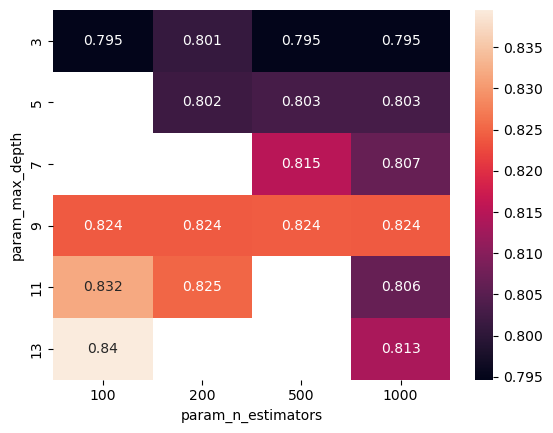

In [25]:
df_gridsearch = pd.DataFrame(results.cv_results_)
plotting_utils.plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")

In [30]:
mode = "gpu-grid"

with timed("XGB-"+mode):
    res, results = do_HPO(model_gpu_xgb,
                            params_xgb,
                                   cuml_accuracy_scorer,
                                   X_train,
                                   y_cpu,
                                   mode=mode)
print("Searched over {} parameters".format(len(results.cv_results_['mean_test_score'])))

gpu-grid selected
Best clf and score XGBClassifier(alpha=0.001, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...) 0.8706077218547632
---

                    XGB-gpu-grid time:  4401.70961
Searched over 405 parameters


In [31]:
print_acc(res, X_train, y_cpu, X_test, y_test_cpu, mode_str=mode)

gpu-grid model accuracy: 0.8719925880432129


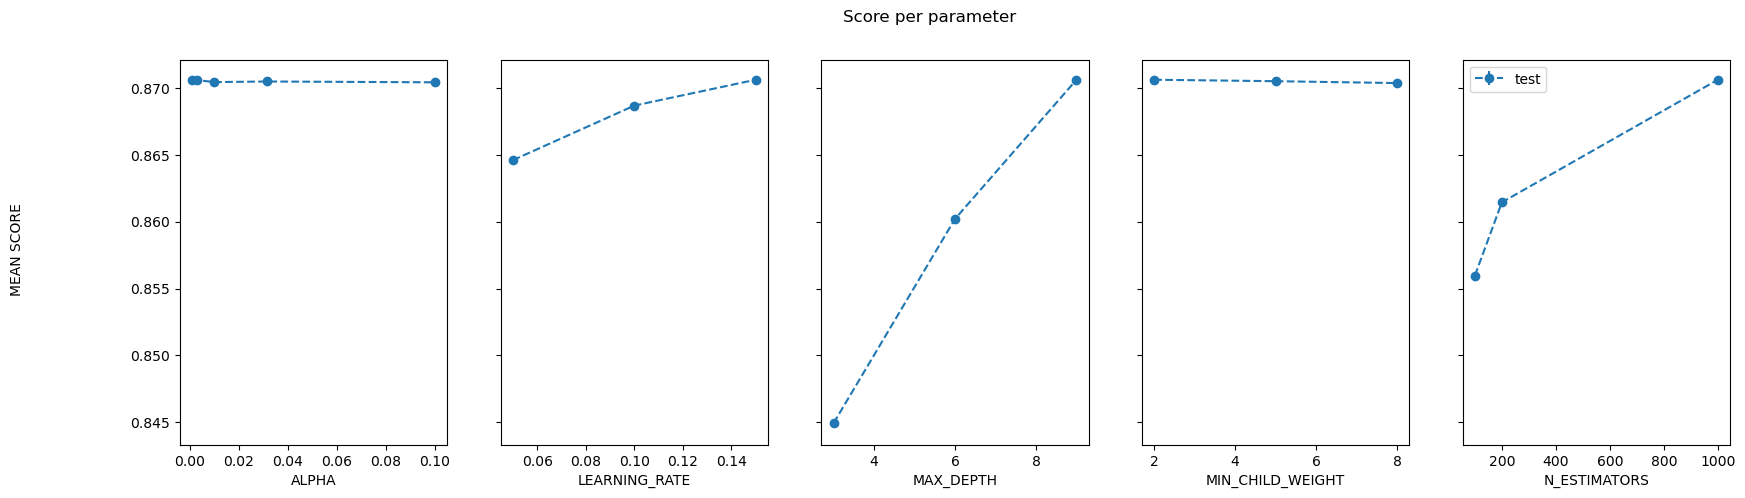

In [32]:
plotting_utils.plot_search_results(results)

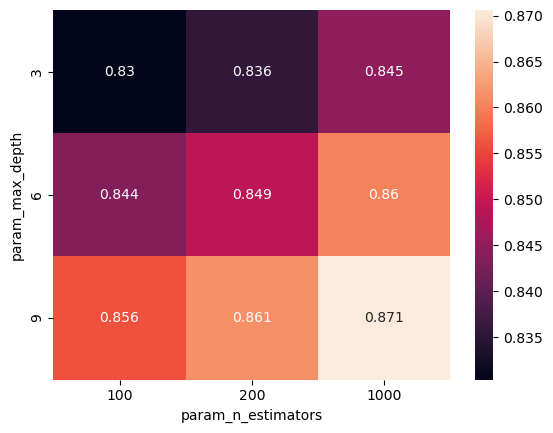

In [33]:
df_gridsearch = pd.DataFrame(results.cv_results_)
plotting_utils.plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")